営業成約の予測

In [1]:
#共通前処理

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import japanize_matplotlib

from IPython.display import display

#表示オプション
np.set_printoptions(suppress=True, precision=4)
pd.options.display.float_format ='{:.4f}'.format

#データフレームですべての表示項目を表示する
pd.set_option('display.max_columns',None)
#グラフのフォント
plt.rcParams['font.size'] = 14

#乱数
random_seed = 123

In [2]:
#混同行列の表示用の関数

def make_cm(matrix, columns):
    #matrix：numpy配列
    #columns：項目名リスト
    
    n = len(columns)
    
    #正解データをn回繰り返すリストを作成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n
    
    #データフレームの作成
    cm = pd.DataFrame(matrix, columns=[pred, columns], index=[act, columns])
    
    return cm

以下からデータの読み込みとデータの確認

In [7]:
#公開データのダウンロードと解凍
#自分で対象のwebサイト行ってダウンロードして解凍した


#回答したものに含まれているbank-full.csvファイルをデータフレームに取り込む
df_all = pd.read_csv(r'C:\Users\shoni\Downloads\bank\bank-full.csv', sep=';')

#項目名を日本語へ
columns = [    '年齢', '職業', '婚姻', '学歴', '債務不履行', '平均残高',
    '住宅ローン', '個人ローン', '連絡手段', '最終通話日',
    '最終通話月', '最終通話秒数', '通話回数_販促中',
    '前回販促後_経過日数', '通話回数_販促前', '前回販促結果',
    '今回販促結果'
          ]
df_all.columns = columns
                    

In [8]:
#上で読み込んだデータの確認

display(df_all.head())

,年齢,職業,婚姻,学歴,債務不履行,平均残高,住宅ローン,個人ローン,連絡手段,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,前回販促結果,今回販促結果
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [9]:
#簡単な統計情報の確認
#対象の行数と列数の確認
print(df_all.shape)
print()

#今回販促結果の値分布確認
print(df_all['今回販促結果'].value_counts())
print()

#営業成功率
rate = df_all['今回販促結果'].value_counts()['yes']/len(df_all)
print(f'営業成功率: {rate:.4f}')

(45211, 17)

no     39922
yes     5289
Name: 今回販促結果, dtype: int64

営業成功率: 0.1170


In [12]:
#欠損値の確認
print(df_all.isnull().sum())

年齢            0
職業            0
婚姻            0
学歴            0
債務不履行         0
平均残高          0
住宅ローン         0
個人ローン         0
連絡手段          0
最終通話日         0
最終通話月         0
最終通話秒数        0
通話回数_販促中      0
前回販促後_経過日数    0
通話回数_販促前      0
前回販促結果        0
今回販促結果        0
dtype: int64


上まででデータの読み込みからデータの確認までが完了したので  
データの前処理、分割処理を実施する

In [13]:
#まずはテキストのラベル値をone-hotエンコーディングにする
#関数に関しては4.2.4で作成しているので詳しくはそっちを見て

#one-hot炎コーディンする処理の関数を定義する
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column], axis=1), df_dummy], axis=1)
    return df

df_all2 = df_all.copy()
df_all2 = enc(df_all2, '職業')
df_all2 = enc(df_all2, '婚姻')
df_all2 = enc(df_all2, '学歴')
df_all2 = enc(df_all2, '連絡手段')
df_all2 = enc(df_all2, '前回販促結果')

#結果
display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,no,2143,yes,no,5,may,261,1,-1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,no,29,yes,no,5,may,151,1,-1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,no,2,yes,yes,5,may,76,1,-1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,no,1506,yes,no,5,may,92,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,no,1,no,no,5,may,198,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [14]:
#yes/noに対しても1/0に置換する

#2値の値を1/0に変換する関数
def enc_bin(df, column):
    df[column] = df[column].map(dict(yes=1, no=0))
    return df

df_all2 = enc_bin(df_all2,'債務不履行')
df_all2 = enc_bin(df_all2,'住宅ローン')
df_all2 = enc_bin(df_all2,'個人ローン')
df_all2 = enc_bin(df_all2,'今回販促結果')

display(df_all2.head())


,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,may,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,may,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,may,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,may,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,may,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


In [15]:
#最終通話月もラベル値となっているため数値へ変換する

month_dict =dict(jan=1, feb=2, mar=3, apr=4, 
    may=5, jun=6, jul=7, aug=8, sep=9, oct=10, 
    nov=11, dec=12)

#月の情報を数値へ変換する関数を定義
def enc_month(df, column):
    df[column] = df[column].map(month_dict)
    return df

df_all2 = enc_month(df_all2, '最終通話月')

display(df_all2.head())

,年齢,債務不履行,平均残高,住宅ローン,個人ローン,最終通話日,最終通話月,最終通話秒数,通話回数_販促中,前回販促後_経過日数,通話回数_販促前,今回販促結果,職業_admin.,職業_blue-collar,職業_entrepreneur,職業_housemaid,職業_management,職業_retired,職業_self-employed,職業_services,職業_student,職業_technician,職業_unemployed,職業_unknown,婚姻_divorced,婚姻_married,婚姻_single,学歴_primary,学歴_secondary,学歴_tertiary,学歴_unknown,連絡手段_cellular,連絡手段_telephone,連絡手段_unknown,前回販促結果_failure,前回販促結果_other,前回販促結果_success,前回販促結果_unknown
0,58,0,2143,1,0,5,5,261,1,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
1,44,0,29,1,0,5,5,151,1,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1
2,33,0,2,1,1,5,5,76,1,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,47,0,1506,1,0,5,5,92,1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1
4,33,0,1,0,0,5,5,198,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1


上までで入力データの前処理が完了した  
以下からデータの分割処理

In [18]:
#入力データ(説明変数)と正解データ(目的変数)の分割
#と訓練データ(学習データ)と検証データの分割

#説明変数
x = df_all2.drop('今回販促結果', axis=1)
#目的変数
y = df_all2['今回販促結果'].values

#訓練データと検証データの分割
#訓練データと検証データの比率：6:4
test_size = 0.4

#ここのパラメータの意味は3.3.で説明済み
from sklearn.model_selection import train_test_split
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size=test_size, random_state=random_seed, stratify=y)


In [26]:
###教科書のやつ
# 入力データと正解データの分割
x = df_all2.drop('今回販促結果', axis=1)
y = df_all2['今回販促結果'].values

# 訓練データと検証データの分割
# 訓練データ60% 検証データ40%の比率で分割する
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=test_size, random_state=random_seed,
  stratify=y)

データの前処理、分割処理が完了したので学習するアルゴリズムを選定する

In [27]:
#候補アルゴリズムのリストを作成
#サポートベクターマシンは使わない(確率値を出せない)

#ロジスティック回帰
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

#決定木
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state=random_seed)

#XGBoost
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4]


In [50]:
#交差検定法を用いて最適なアルゴリズムを選定する
#詳しくは4.5.3を参照

from sklearn.model_selection import StratifiedKFold
#学習データの分割数を指定
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    # 交差検定法の実行
    #scoringは計算方法。デフォルトは精度になっているが今回はroc_auc値を活用することにする
    scores = cross_val_score(algorithm , x_train, y_train,
        cv=stratifiedkfold, scoring='roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均スコア: {score:.4f}  個別スコア: {scores}  {name}')

平均スコア: 0.8325  個別スコア: [0.8276 0.8287 0.8412]  LogisticRegression
平均スコア: 0.6958  個別スコア: [0.6917 0.7023 0.6935]  DecisionTreeClassifier
平均スコア: 0.9200  個別スコア: [0.9259 0.9196 0.9145]  RandomForestClassifier
[18:32:22] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:23] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:32:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
平均スコア: 0.9256  個別スコア: [0.9263 0.9272 0.92

モデルの選定ができたので学習、予測、評価を実施する

In [51]:
#アルゴリズム選択：xgboostを利用する

algorithm = XGBClassifier(random_state=random_seed)

#学習
algorithm.fit(x_train, y_train )

#予測
y_pred = algorithm.predict(x_test)

[18:32:35] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [52]:
#モデルの評価

#混同行列を取得する
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(confusion_matrix(y_test, y_pred), ['失敗','成功'])

display(df_matrix)
print()
#適合率、再現率、　f値
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f'適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f}')

予測結果      
             失敗    成功
正解データ 失敗  15371   598
      成功   1102  1014


適合率: 0.6290 再現率: 0.4792 F値: 0.5440


学習からモデルの評価もでは完了した  
これからチューニングを行う

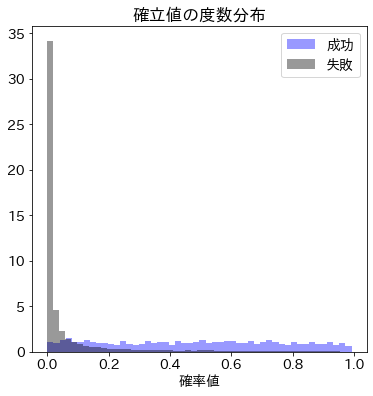

In [39]:
#確率値を取り出し、度数分布のグラフを作成する

import seaborn as sns

#y=0の確立値を取得する
y_proba0 = algorithm.predict_proba(x_test)[:,1]

#y_test=0,y_test=1でデータを分割する
y0 = y_proba0[y_test==0]
y1 = y_proba0[y_test==1]

#度数分布を描画する
plt.figure(figsize=(6,6))
plt.title('確立値の度数分布')
sns.distplot(y1, kde=False, norm_hist=True, bins=50, color='b', label='成功')
sns.distplot(y0, kde=False, norm_hist=True, bins=50, color='k', label='失敗')

plt.xlabel('確率値')
plt.legend()
plt.show()

#デフォルトの閾値0.5をずらす

In [40]:
#閾値を変更した際の予測関数を定義する
#閾値が0.5以外の場合を予測する
def pred(algorithm, x, thres):
    
    #確率値の取得
    y_proba = algorithm.predict_proba(x)
    
    #予測結果1の確率値
    y_proba1 = y_proba[:,1]
    
    #予測結果1の確率値>閾値
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [42]:
#閾値を0.05刻みに変化させる。適合率、再現率、F値を計算する
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
    y_pred = pred(algorithm, x_test, thres)
    pred_sum = y_pred.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary'
    )
    print(f'閾値: {thres:.2f} 陽性予測数: {pred_sum} 適合率: {precision:.4f} 再現率: {recall:.4f} F値: {fscore:.4f}')
    

閾値: 0.50 陽性予測数: 1612 適合率: 0.6290 再現率: 0.4792 F値: 0.5440
閾値: 0.45 陽性予測数: 1839 適合率: 0.6117 再現率: 0.5317 F値: 0.5689
閾値: 0.40 陽性予測数: 2041 適合率: 0.6022 再現率: 0.5808 F値: 0.5913
閾値: 0.35 陽性予測数: 2304 適合率: 0.5820 再現率: 0.6337 F値: 0.6068
閾値: 0.30 陽性予測数: 2544 適合率: 0.5688 再現率: 0.6838 F値: 0.6210
閾値: 0.25 陽性予測数: 2831 適合率: 0.5440 再現率: 0.7278 F値: 0.6226
閾値: 0.20 陽性予測数: 3184 適合率: 0.5135 再現率: 0.7727 F値: 0.6170
閾値: 0.15 陽性予測数: 3616 適合率: 0.4806 再現率: 0.8214 F値: 0.6064
閾値: 0.10 陽性予測数: 4277 適合率: 0.4361 再現率: 0.8814 F値: 0.5835
閾値: 0.05 陽性予測数: 5519 適合率: 0.3629 再現率: 0.9466 F値: 0.5247


In [47]:
#上の結果で最適な閾値は0.3と判断した

y_final = pred(algorithm, x_test, 0.3)

#混同行列を出力する
df_matrix2 = make_cm(
    confusion_matrix(y_test, y_final), ['失敗','成功']
)
display(df_matrix2)

print()

#適合率、再現率、F値を再計算する
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_final, average='binary'
)
print(f'適合率: {precision:.4f}  再現率: {recall:.4f} F値: {fscore:.4f}')



予測結果      
             失敗    成功
正解データ 失敗  14872  1097
      成功    669  1447


適合率: 0.5688  再現率: 0.6838 F値: 0.6210


以下から重要度分析

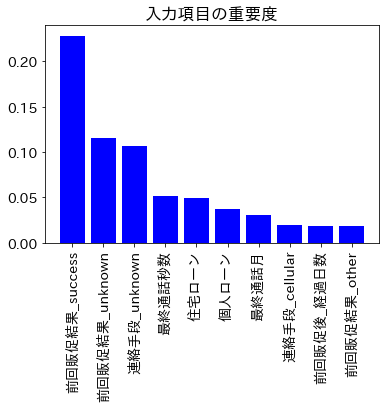

In [53]:
#重要度分析
#コードは4.4.4と同じ

#重要度ベクトルの取得
importances = algorithm.feature_importances_

#項目名をキーにseriesを作成
w = pd.Series(importances, index=x.columns)

#値の大きい順にソートする
u = w.sort_values(ascending=False)

#10個だけ出力する
v = u[:10]

#重要度の棒グラフを表示する
plt.title('入力項目の重要度')
plt.bar(range(len(v)), v, color='b', align='center')
plt.xticks(range(len(v)), v.index, rotation=90)
plt.show()

#出力するグラフからは営業成功に向けていい方向へ作用するかはわからない

上のグラフからは影響度が営業成功に向けて、いい方向へ進むものかどうかは判断できない  
なので上位5項目に対して個別にヒストグラムを描画し良い方向に働いているのかどうか確認することにする

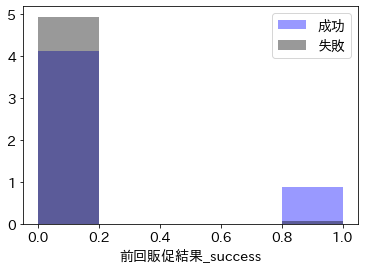

In [55]:
#前回入力結果_successの重要度を調べる

column = '前回販促結果_success'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=5, color='b', label='成功')

sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=5, color='k', label='失敗')

plt.legend()
plt.show()

#グラフの上部が青色なら良い意味の重要度

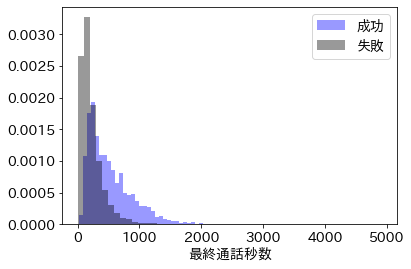

In [56]:
#最終通話秒数の重要度を調べる

column = '最終通話秒数'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=50, color='b', label='成功')

sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=50, color='k', label='失敗')

plt.legend()
plt.show()

#グラフの上部が青色なら良い意味の重要度

上の表は通話時間が長ければ成功の可能性が高いことを意味する

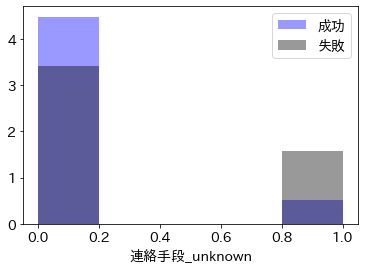

In [58]:
#連絡手段_unknownの重要度を調べる

column = '連絡手段_unknown'

sns.distplot(x_test[y_test==1][column], kde=False, norm_hist=True, bins=5, color='b', label='成功')

sns.distplot(x_test[y_test==0][column], kde=False, norm_hist=True, bins=5, color='k', label='失敗')

plt.legend()
plt.show()

#グラフの上部が青色なら良い意味の重要度